In [1]:
import numpy as np
import h5py
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Read the HP5 file
hfine = h5py.File('/content/drive/MyDrive/Colab Notebooks/vel3_cutout_les_fine.h5', 'r')
hcoarse = h5py.File('/content/drive/MyDrive/Colab Notebooks/vel3_cutout_les_coarse.h5', 'r')

In [3]:
a = len(list(hfine.keys())) - 3
b = len(list(hcoarse.keys())) - 3

In [4]:
def readsave(arg1,arg2):
  n1 = np.array(arg1[arg2][:])
  return n1

In [5]:
nfine = np.array([])
for i in range(a):
  n1 = readsave(hfine,list(hfine.keys())[i])
  n1 = n1.swapaxes(0,2)
  n1 = n1[:,:,0,0:2].reshape(n1.shape[0]**2,2)
  n1 = n1[:,np.newaxis,:]
  if i == 0:
    nfine = n1
  else:
    nfine = np.append(nfine,n1,axis=1)
    #print(n.shape)

In [6]:
ncoarse = np.array([])
for i in range(b):
  n1 = readsave(hcoarse,list(hcoarse.keys())[i])
  n1 = n1.swapaxes(0,2)
  n1 = n1[:,:,0,0:2].reshape(n1.shape[0]**2,2)
  n1 = n1[:,np.newaxis,:]
  if i == 0:
    ncoarse = n1
  else:
    ncoarse = np.append(ncoarse,n1,axis=1)
    #print(n.shape)

In [7]:
nfine.shape

(65536, 64, 2)

In [8]:
#Calculate subgrid stresses from filtered fine matrix UiUj
def true_sgs(ncoarse,nfine):
  Uij = np.multiply(nfine[:,:,0],nfine[:,:,1])
  Uii = np.multiply(nfine[:,:,0],nfine[:,:,0])
  Ujj = np.multiply(nfine[:,:,1],nfine[:,:,1])
  tau_Uij = Uij[::64,:] - np.multiply(ncoarse[:,:,0],ncoarse[:,:,1])
  tau_Uii = Uii[::64,:] - np.multiply(ncoarse[:,:,0],ncoarse[:,:,0])
  tau_Ujj = Ujj[::64,:] - np.multiply(ncoarse[:,:,1],ncoarse[:,:,1])

  return tau_Uii,tau_Uij,tau_Ujj

tau_Uii,tau_Uij,tau_Ujj = true_sgs(ncoarse,nfine)

In [9]:
#Functions for Derivatives assuming periodic boundary conditions
def gradient(N,dx):
  A = np.zeros((N,N))
  for i in range(N-1):
    A[i,i+1] = 1
    A[i+1,i] = -1
  
  A3 = A
  A3[N-1,0] = 1
  A3[0,N-1] = -1
  A3 = A3/(2*dx)
  return A3

def second_deriv(N,dx):
  A = np.zeros((N,N))
  for i in range(N):
    A[i,i] = -2
  for i in range(N-1):
    A[i,i+1] = 1
    A[i+1,i] = 1
  
  A3 = A
  A3[N-1,0] = 1
  A3[0,N-1] = 1
  A3 = A3/(dx**2)
  return A3

In [10]:
#Computing the derivative operator matrices for dx = 2*pi
N = ncoarse.shape[0]
dx = 2*np.pi/ncoarse.shape[1]
A = gradient(ncoarse.shape[0],dx)
B = second_deriv(1024,dx)

In [11]:
#Computing derivative features
ux = np.zeros((ncoarse.shape[0],ncoarse.shape[1]))
vx = np.zeros((ncoarse.shape[0],ncoarse.shape[1]))
uxx = np.zeros((ncoarse.shape[0],ncoarse.shape[1]))
vxx = np.zeros((ncoarse.shape[0],ncoarse.shape[1]))

for i in range(ncoarse.shape[1]):
  ux[:,i] = A.dot(ncoarse[:,i,0])
  vx[:,i] = A.dot(ncoarse[:,i,1])
  uxx[:,i] = B.dot(ncoarse[:,i,0])
  vxx[:,i] = B.dot(ncoarse[:,i,1])

ux = ux[:,:,np.newaxis]
vx = vx[:,:,np.newaxis]
uxx = uxx[:,:,np.newaxis]
vxx = vxx[:,:,np.newaxis]

In [12]:
#Smagorinsky estimation of Tau (SG Stresses)
Cs = .1678

def smag_compute(input_coarse,input_fine):
  ux = input_coarse[:,:,2][:,:,np.newaxis]
  vx = input_coarse[:,:,3][:,:,np.newaxis]
  
  input_coarse = input_coarse[:,:,0:2]
  tau_Uii,tau_Uij,tau_Ujj = true_sgs(input_coarse,input_fine)
  
  Sii = ux
  Sjj = vx
  Sij = (ux + vx)/2
  tau_kk = (tau_Uii + tau_Ujj)/2

  tau_sii = -2*(Cs*dx**2)*np.multiply(np.sqrt(2*np.multiply(Sii,Sii)),Sii) + tau_kk[:,:,np.newaxis]
  tau_sij = -2*(Cs*dx**2)*np.multiply(np.sqrt(2*np.multiply(Sij,Sij)),Sij) + tau_kk[:,:,np.newaxis]
  tau_sjj = -2*(Cs*dx**2)*np.multiply(np.sqrt(2*np.multiply(Sjj,Sjj)),Sjj) + tau_kk[:,:,np.newaxis]

  op_smag = np.concatenate((tau_sii,tau_sij,tau_sjj),axis=0).reshape(1024*3,input_coarse.shape[1])
  return op_smag

In [13]:
#Setup Input and Output features
input = ncoarse
input = np.append(input,ux,axis=2)
input = np.append(input,vx,axis=2)
input = np.append(input,uxx,axis=2)
input = np.append(input,vxx,axis=2)

output = tau_Uii[:,:,np.newaxis]
output = np.append(output,tau_Uij[:,:,np.newaxis],axis=2)
output = np.append(output,tau_Ujj[:,:,np.newaxis],axis=2)

input = input.reshape(input.shape[0]*input.shape[2],input.shape[1]).transpose()
output = output.reshape(output.shape[0]*output.shape[2],output.shape[1]).transpose()

In [14]:
#Setup validation and demean all inputs
mean_ip = input.mean(axis=0,keepdims=True)
mean_op = output.mean(axis=0,keepdims=True)

nn_im = input - mean_ip
nn_om = output - mean_op

nn_im_test = nn_im[60:64,:]
nn_om_test = nn_om[60:64,:]
nn_fine_test = nfine[:,60:64,:]

nn_im = nn_im[:60,:]
nn_om = nn_om[:60,:]
from sklearn.model_selection import train_test_split

all_indices = list(range(nn_im.shape[0]))
train, dev = train_test_split(all_indices, test_size=0.2)

nn_ipm = nn_im[train,:]
nn_idm = nn_im[dev,:]
nn_opm = nn_om[train,:]
nn_odm = nn_om[dev,:]

nn_ipm_small = nn_ipm[:,:1024*2]
nn_idm_small = nn_idm[:,:1024*2]
nn_opm_small = nn_opm
nn_odm_small = nn_odm

print(nn_ipm.shape, nn_opm.shape, nn_idm.shape, nn_odm.shape)
print(nn_ipm_small.shape, nn_opm_small.shape, nn_idm_small.shape, nn_odm_small.shape)
print(nn_im_test.shape,nn_om_test.shape)

(48, 6144) (48, 3072) (12, 6144) (12, 3072)
(48, 2048) (48, 3072) (12, 2048) (12, 3072)
(4, 6144) (4, 3072)


In [15]:
#Train NN to model this one timestep
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras import optimizers
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K

In [18]:
# Build model
deep_approx = keras.models.Sequential()
deep_approx.add(layers.Dense(1000, input_dim=nn_ipm_small.shape[1], activation='sigmoid'))
deep_approx.add(layers.Dense(2000, activation='relu'))
deep_approx.add(layers.Dense(2000, activation='relu'))
deep_approx.add(layers.Dense(output.shape[1], activation='linear'))

# Compile model
deep_approx.compile(loss='mse', optimizer='adam')

# Fit!
History = deep_approx.fit(nn_ipm_small, nn_opm_small, epochs=500,
                          validation_data=(nn_idm_small, nn_odm_small),verbose=0)

In [19]:
# Build model
deep_approx1 = keras.models.Sequential()
deep_approx1.add(layers.Dense(1000, input_dim=input.shape[1], activation='sigmoid'))
deep_approx1.add(layers.Dense(2000, activation='relu'))
deep_approx1.add(layers.Dense(2000, activation='relu'))
deep_approx1.add(layers.Dense(output.shape[1], activation='linear'))

# Compile model
deep_approx1.compile(loss='mse', optimizer='adam')

# Fit!
History1 = deep_approx1.fit(nn_ipm, nn_opm, epochs=500,
                          validation_data=(nn_idm, nn_odm),verbose=0)

In [20]:
deep_approx.summary()
deep_approx1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_8 (ModuleWrap (None, 1000)              2049000   
_________________________________________________________________
module_wrapper_9 (ModuleWrap (None, 2000)              2002000   
_________________________________________________________________
module_wrapper_10 (ModuleWra (None, 2000)              4002000   
_________________________________________________________________
module_wrapper_11 (ModuleWra (None, 3072)              6147072   
Total params: 14,200,072
Trainable params: 14,200,072
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_12 (ModuleWra (None, 1000)              6145000   
____________________

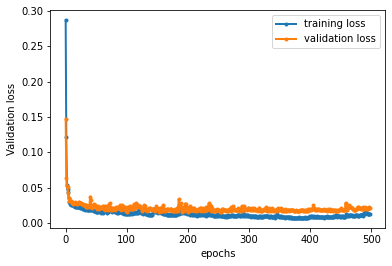

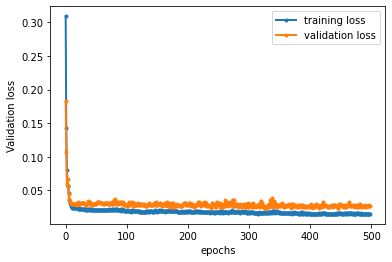

In [21]:
idx0 = 1
import matplotlib.pyplot as plt

plt.figure()
plt.plot(History.history['loss'][idx0:], '.-', lw=2)
plt.plot(History.history['val_loss'][idx0:], '.-', lw=2)
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

plt.figure()
plt.plot(History1.history['loss'][idx0:], '.-', lw=2)
plt.plot(History1.history['val_loss'][idx0:], '.-', lw=2)
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

In [22]:
#Test all estimators
test_input = nn_im_test
test_fine = nn_fine_test
test_output = nn_om_test

test_pred_m1 = deep_approx.predict(test_input[:,:1024*2])
test_pred_m2 = deep_approx1.predict(test_input)

test_coarse = (test_input + mean_ip).transpose().reshape(1024,test_input.shape[0],6)
test_pred_smag = smag_compute(test_coarse,test_fine).transpose() - mean_op

In [23]:
test_input.shape

(4, 6144)

In [28]:
#Reshape the stress vector predictions
test_pred_m1 = test_pred_m1.reshape(4,1024,3)
test_pred_m2 = test_pred_m2.reshape(4,1024,3)
test_pred_smag = test_pred_smag.reshape(4,1024,3)
test_true = test_output.reshape(4,1024,3)

tau_11_m1 = test_pred_m1[:,:,0]
tau_11_m2 = test_pred_m2[:,:,0]
tau_11_smag = test_pred_smag[:,:,0]
tau_11_true = test_true[:,:,0]

tau_12_m1 = test_pred_m1[:,:,1]
tau_12_m2 = test_pred_m2[:,:,1]
tau_12_smag = test_pred_smag[:,:,1]
tau_12_true = test_true[:,:,1]


tau_22_m1 = test_pred_m1[:,:,2]
tau_22_m2 = test_pred_m2[:,:,2]
tau_22_smag = test_pred_smag[:,:,2]
tau_22_true = test_true[:,:,2]

print(tau_11_m1.shape,tau_11_m2.shape,tau_11_smag.shape,tau_11_true.shape)
print(tau_12_m1.shape,tau_12_m2.shape,tau_12_smag.shape,tau_12_true.shape)
print(tau_22_m1.shape,tau_22_m2.shape,tau_22_smag.shape,tau_22_true.shape)

(4, 1024) (4, 1024) (4, 1024) (4, 1024)
(4, 1024) (4, 1024) (4, 1024) (4, 1024)
(4, 1024) (4, 1024) (4, 1024) (4, 1024)


In [32]:
#MAE for various Taus
error_t11m1 = np.abs(tau_11_m1 - tau_11_true)
error_t11m2 = np.abs(tau_11_m2 - tau_11_true)
error_t11smag = np.abs(tau_11_smag - tau_11_true)
error_t12m1 = np.abs(tau_12_m1 - tau_12_true)
error_t12m2 = np.abs(tau_12_m2 - tau_12_true)
error_t12smag = np.abs(tau_12_smag - tau_12_true)
error_t22m1 = np.abs(tau_22_m1 - tau_22_true)
error_t22m2 = np.abs(tau_22_m2 - tau_22_true)
error_t22smag = np.abs(tau_22_smag - tau_22_true)

mean_t11m1 = np.mean(np.mean(error_t11m1,axis=1))
sd_t11m1 = np.std(np.mean(error_t11m1,axis=1))

mean_t11m2 = np.mean(np.mean(error_t11m2,axis=1))
sd_t11m2 = np.std(np.mean(error_t11m2,axis=1))

mean_t11smag = np.mean(np.mean(error_t11smag,axis=1))
sd_t11smag = np.std(np.mean(error_t11smag,axis=1))

mean_t12m1 = np.mean(np.mean(error_t12m1,axis=1))
sd_t12m1 = np.std(np.mean(error_t12m1,axis=1))

mean_t12m2 = np.mean(np.mean(error_t12m2,axis=1))
sd_t12m2 = np.std(np.mean(error_t12m2,axis=1))

mean_t12smag = np.mean(np.mean(error_t12smag,axis=1))
sd_t12smag = np.std(np.mean(error_t12smag,axis=1))

mean_t22m1 = np.mean(np.mean(error_t22m1,axis=1))
sd_t22m1 = np.std(np.mean(error_t22m2,axis=1))

mean_t22m2 = np.mean(np.mean(error_t22m2,axis=1))
sd_t22m2 = np.std(np.mean(error_t22m2,axis=1))

mean_t22smag = np.mean(np.mean(error_t22smag,axis=1))
sd_t22smag = np.std(np.mean(error_t22smag,axis=1))

print(mean_t11m1,sd_t11m1,mean_t11m2,sd_t11m2,mean_t11smag,sd_t11smag)
print(mean_t12m1,sd_t12m1,mean_t12m2,sd_t12m2,mean_t12smag,sd_t12smag)
print(mean_t22m1,sd_t22m1,mean_t22m2,sd_t22m2,mean_t22smag,sd_t22smag)

0.09775593 0.022710096 0.08432464 0.039012704 0.6757772990150385 0.08132483556044193
0.100405656 0.0419078 0.078517005 0.030088296 0.6556403084951781 0.0783434668589625
0.10546816 0.04757712 0.089077115 0.04757712 0.7153751256617901 0.08768364101246555


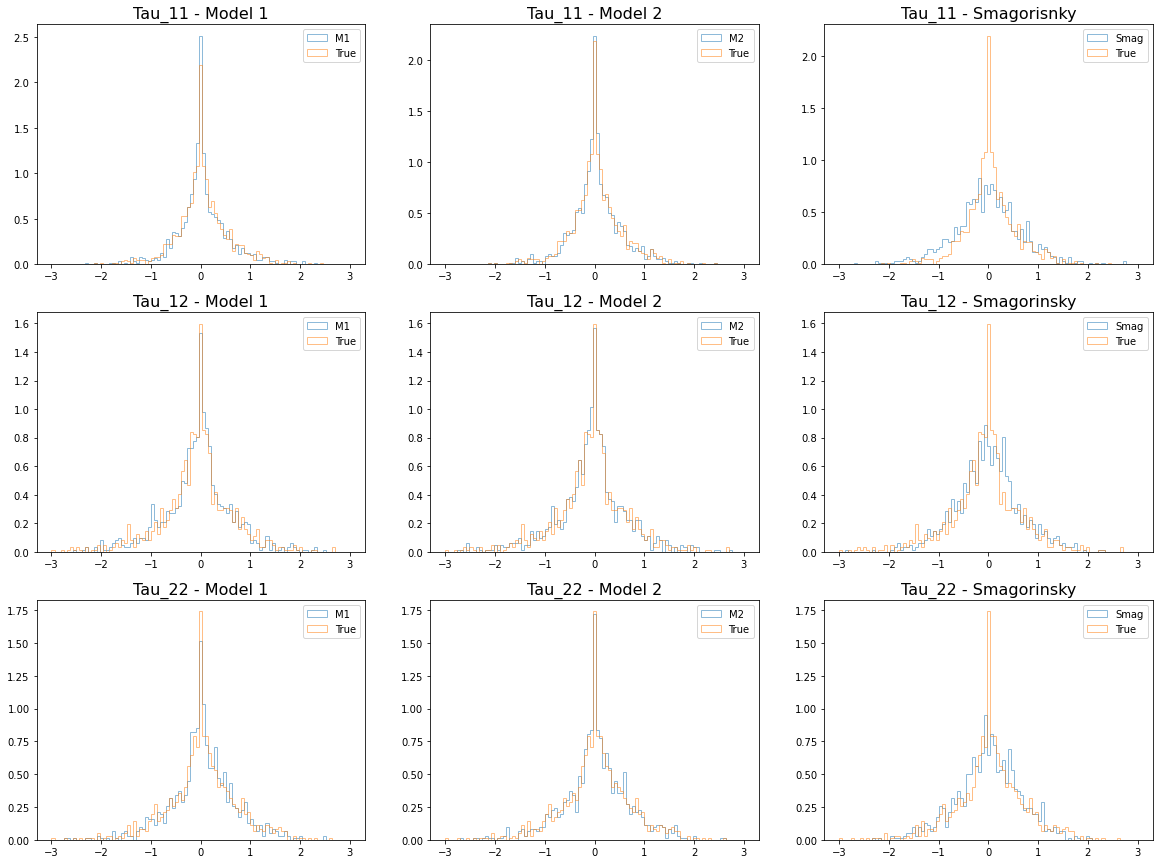

In [33]:
#Plot PDF
from matplotlib import pyplot

fig = pyplot.figure(figsize = (20, 15))

x = tau_11_m1[1,:]
y = tau_11_true[1,:]
bins = np.linspace(-3, 3, 100)

a = fig.add_subplot(331)
a.hist(x, bins, alpha=0.5, label='M1', density = True, histtype='step')
a.hist(y, bins, alpha=0.5, label='True', density = True, histtype = 'step')
a.set_title('Tau_11 - Model 1',fontsize=16)

a.legend(loc='upper right')

x = tau_11_m2[1,:]
y = tau_11_true[1,:]

a = fig.add_subplot(332)
a.hist(x, bins, alpha=0.5, label='M2', density = True, histtype='step')
a.hist(y, bins, alpha=0.5, label='True', density = True, histtype='step')
a.set_title('Tau_11 - Model 2',fontsize=16)

a.legend(loc='upper right')

x = tau_11_smag[1,:]
y = tau_11_true[1,:]

a = fig.add_subplot(333)
a.hist(x, bins, alpha=0.5, label='Smag', density = True, histtype='step')
a.hist(y, bins, alpha=0.5, label='True', density = True, histtype='step')
a.set_title('Tau_11 - Smagorisnky',fontsize=16)

a.legend(loc='upper right')

x = tau_12_m1[1,:]
y = tau_12_true[1,:]

a = fig.add_subplot(334)
a.hist(x, bins, alpha=0.5, label='M1', density = True, histtype='step')
a.hist(y, bins, alpha=0.5, label='True', density = True, histtype='step')
a.set_title('Tau_12 - Model 1',fontsize=16)

a.legend(loc='upper right')

x = tau_12_m2[1,:]
y = tau_12_true[1,:]

a = fig.add_subplot(335)
a.hist(x, bins, alpha=0.5, label='M2', density = True, histtype='step')
a.hist(y, bins, alpha=0.5, label='True', density = True, histtype='step')
a.set_title('Tau_12 - Model 2',fontsize=16)

a.legend(loc='upper right')

x = tau_12_smag[1,:]
y = tau_12_true[1,:]

a = fig.add_subplot(336)
a.hist(x, bins, alpha=0.5, label='Smag', density = True, histtype='step')
a.hist(y, bins, alpha=0.5, label='True', density = True, histtype='step')
a.set_title('Tau_12 - Smagorinsky',fontsize=16)

a.legend(loc='upper right')

x = tau_22_m1[1,:]
y = tau_22_true[1,:]

a = fig.add_subplot(337)
a.hist(x, bins, alpha=0.5, label='M1', density = True, histtype='step')
a.hist(y, bins, alpha=0.5, label='True', density = True, histtype='step')
a.set_title('Tau_22 - Model 1',fontsize=16)

a.legend(loc='upper right')

x = tau_22_m2[1,:]
y = tau_22_true[1,:]

a = fig.add_subplot(338)
a.hist(x, bins, alpha=0.5, label='M2', density = True, histtype='step')
a.hist(y, bins, alpha=0.5, label='True', density = True, histtype='step')
a.set_title('Tau_22 - Model 2',fontsize=16)

a.legend(loc='upper right')

x = tau_22_smag[1,:]
y = tau_22_true[1,:]

a = fig.add_subplot(339)
a.hist(x, bins, alpha=0.5, label='Smag', density = True, histtype='step')
a.hist(y, bins, alpha=0.5, label='True', density = True, histtype='step')
a.set_title('Tau_22 - Smagorinsky',fontsize=16)

a.legend(loc='upper right')

pyplot.show()